In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix, dmatrices
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
# Carregar os dados
df = pd.read_csv("/content/previsao_de_renda.csv")

In [3]:
# Remover linhas com valores ausentes
df = df.dropna()

In [4]:
# Calcular o log da renda
df['log_renda'] = np.log(df['renda'])


In [5]:
# Identificar variáveis qualitativas
qual_vars = df.select_dtypes(include=['object']).columns

In [6]:
# Criar fórmula para o modelo
formula = "log_renda ~ "
for col in df.columns:
    if col not in ['renda', 'log_renda']:
        if col in qual_vars:
            # Para variáveis qualitativas, use C() para criar dummies
            most_frequent = df[col].mode()[0]
            formula += f"C({col}, Treatment(reference='{most_frequent}')) + "
        else:
            formula += f"{col} + "
formula = formula.rstrip(" + ")

In [7]:
# Criar matriz de design e variável resposta
y, X = dmatrices(formula, data=df, return_type='dataframe')

In [8]:
# Ajustar o modelo
model = sm.OLS(y, X).fit()

In [9]:
# Imprimir o sumário do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     178.0
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:35:10   Log-Likelihood:                -13551.
No. Observations:               12427   AIC:                         2.718e+04
Df Residuals:                   12387   BIC:                         2.748e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [10]:
# Avaliar os parâmetros
coef = model.params
p_values = model.pvalues

print("\nParâmetros significativos (p-value < 0.05):")
for var, coef_value, p_value in zip(coef.index, coef, p_values):
    if p_value < 0.05:
        print(f"{var}: {coef_value:.4f} (p-value: {p_value:.4f})")


Parâmetros significativos (p-value < 0.05):
Intercept: 6.5363 (p-value: 0.0000)
C(data_ref, Treatment(reference='2015-09-01'))[T.2015-06-01]: 0.0808 (p-value: 0.0221)
C(data_ref, Treatment(reference='2015-09-01'))[T.2015-12-01]: 0.0805 (p-value: 0.0226)
C(sexo, Treatment(reference='F'))[T.M]: 0.7885 (p-value: 0.0000)
posse_de_veiculo[T.True]: 0.0424 (p-value: 0.0027)
posse_de_imovel[T.True]: 0.0798 (p-value: 0.0000)
C(tipo_renda, Treatment(reference='Assalariado'))[T.Empresário]: 0.1564 (p-value: 0.0000)
C(tipo_renda, Treatment(reference='Assalariado'))[T.Servidor público]: 0.0574 (p-value: 0.0098)
C(educacao, Treatment(reference='Secundário'))[T.Superior completo]: 0.1111 (p-value: 0.0000)
C(estado_civil, Treatment(reference='Casado'))[T.Separado]: 0.3204 (p-value: 0.0040)
C(estado_civil, Treatment(reference='Casado'))[T.Solteiro]: 0.2630 (p-value: 0.0157)
C(estado_civil, Treatment(reference='Casado'))[T.Viúvo]: 0.3666 (p-value: 0.0015)
id_cliente: -0.0000 (p-value: 0.0347)
qtd_filho

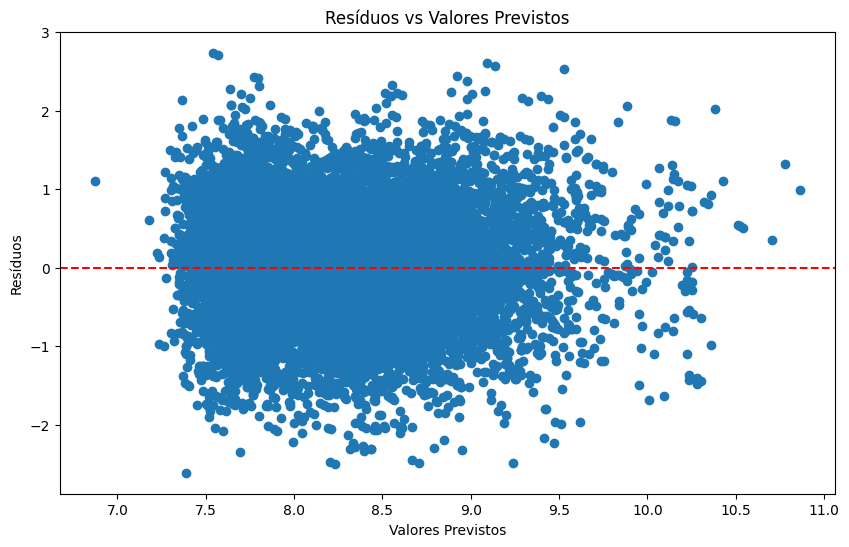

In [11]:
# Plotar resíduos
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Previstos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [12]:
# Calcular o log da renda
df['log_renda'] = np.log(df['renda'])

In [13]:
# Função para criar e ajustar o modelo
def fit_model(formula, data):
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    model = sm.OLS(y, X).fit()
    return model

In [14]:
# Criar fórmula inicial para o modelo
qual_vars = df.select_dtypes(include=['object']).columns
formula = "log_renda ~ " + " + ".join([f"C({col}, Treatment(reference='{df[col].mode()[0]}'))" if col in qual_vars else col for col in df.columns if col not in ['renda', 'log_renda']])

In [15]:
# Ajustar o modelo inicial
initial_model = fit_model(formula, df)
print("Modelo Inicial:")
print(initial_model.summary())

Modelo Inicial:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     178.0
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:35:25   Log-Likelihood:                -13551.
No. Observations:               12427   AIC:                         2.718e+04
Df Residuals:                   12387   BIC:                         2.748e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [16]:
# Encontrar a variável menos significante
p_values = initial_model.pvalues[1:]  # Excluir o intercepto
least_significant_var = p_values.idxmax()

In [17]:
# Remover a variável menos significante da fórmula
new_formula = formula.replace(f"{least_significant_var} + ", "").replace(f" + {least_significant_var}", "")

In [18]:
# Ajustar o novo modelo
new_model = fit_model(new_formula, df)
print("\nNovo Modelo (após remover a variável menos significante):")
print(new_model.summary())


Novo Modelo (após remover a variável menos significante):
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     178.0
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:35:33   Log-Likelihood:                -13551.
No. Observations:               12427   AIC:                         2.718e+04
Df Residuals:                   12387   BIC:                         2.748e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [19]:
# Comparar os coeficientes
print("\nComparação dos coeficientes:")
common_vars = set(initial_model.params.index) & set(new_model.params.index)
for var in common_vars:
    initial_coef = initial_model.params[var]
    new_coef = new_model.params[var]
    diff = abs((new_coef - initial_coef) / initial_coef) * 100 if initial_coef != 0 else 0
    print(f"{var}: Inicial = {initial_coef:.4f}, Novo = {new_coef:.4f}, Diferença % = {diff:.2f}%")


Comparação dos coeficientes:
C(estado_civil, Treatment(reference='Casado'))[T.Viúvo]: Inicial = 0.3666, Novo = 0.3666, Diferença % = 0.00%
C(educacao, Treatment(reference='Secundário'))[T.Pós graduação]: Inicial = 0.1164, Novo = 0.1164, Diferença % = 0.00%
C(data_ref, Treatment(reference='2015-09-01'))[T.2015-03-01]: Inicial = 0.0580, Novo = 0.0580, Diferença % = 0.00%
C(data_ref, Treatment(reference='2015-09-01'))[T.2015-10-01]: Inicial = 0.0314, Novo = 0.0314, Diferença % = 0.00%
posse_de_imovel[T.True]: Inicial = 0.0798, Novo = 0.0798, Diferença % = 0.00%
C(educacao, Treatment(reference='Secundário'))[T.Primário]: Inicial = 0.0200, Novo = 0.0200, Diferença % = 0.00%
C(educacao, Treatment(reference='Secundário'))[T.Superior completo]: Inicial = 0.1111, Novo = 0.1111, Diferença % = 0.00%
C(tipo_renda, Treatment(reference='Assalariado'))[T.Bolsista]: Inicial = 0.1987, Novo = 0.1987, Diferença % = 0.00%
C(sexo, Treatment(reference='F'))[T.M]: Inicial = 0.7885, Novo = 0.7885, Diferença 

Text(0, 0.5, 'Resíduos')

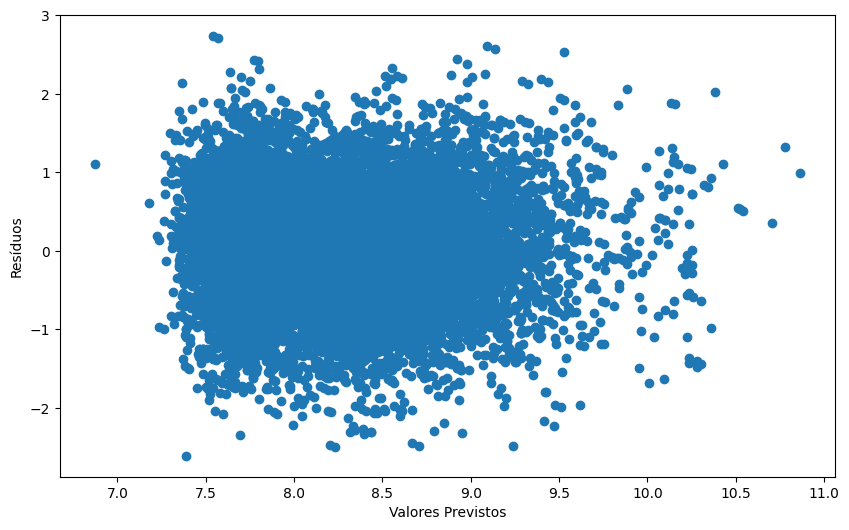

In [20]:
# Plotar resíduos do novo modelo
plt.figure(figsize=(10, 6))
plt.scatter(new_model.fittedvalues, new_model.resid)
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')

In [21]:
# Função para converter string para float, tratando erros
def safe_float(val):
    try:
        return float(val)
    except (ValueError, TypeError):
        return np.nan

In [22]:
# Converter colunas numéricas para float
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    df[col] = df[col].apply(safe_float)

In [23]:
# Remover linhas com valores ausentes
df = df.dropna()

In [24]:
# Calcular o log da renda
df['log_renda'] = np.log(df['renda'])

In [25]:
# Função para criar e ajustar o modelo
def fit_model(formula, data):
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    model = sm.OLS(y, X).fit()
    return model

In [26]:
# Criar fórmula inicial
qual_vars = df.select_dtypes(include=['object']).columns
formula = "log_renda ~ " + " + ".join([f"C({col}, Treatment(reference='{df[col].mode()[0]}'))" if col in qual_vars else col for col in df.columns if col not in ['renda', 'log_renda']])

In [27]:
# Ajustar o modelo inicial
initial_model = fit_model(formula, df)
print("Modelo Inicial:")
print(initial_model.summary())

Modelo Inicial:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     178.0
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:35:51   Log-Likelihood:                -13551.
No. Observations:               12427   AIC:                         2.718e+04
Df Residuals:                   12387   BIC:                         2.748e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [28]:
# Processo iterativo de remoção de variáveis
current_formula = formula
current_model = initial_model
while True:
    p_values = current_model.pvalues[1:]  # Excluir o intercepto
    max_p_value = p_values.max()
    if max_p_value <= 100:
        break
    least_significant_var = p_values.idxmax()
    current_formula = current_formula.replace(f"{least_significant_var} + ", "").replace(f" + {least_significant_var}", "")
    current_model = fit_model(current_formula, df)


In [29]:
# Modelo final
final_model = current_model
print("\nModelo Final:")
print(final_model.summary())


Modelo Final:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     178.0
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:35:56   Log-Likelihood:                -13551.
No. Observations:               12427   AIC:                         2.718e+04
Df Residuals:                   12387   BIC:                         2.748e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [30]:
# Comparação dos modelos
print("\nComparação dos modelos:")
print(f"R-squared: Inicial = {initial_model.rsquared:.4f}, Final = {final_model.rsquared:.4f}")
print(f"Adj. R-squared: Inicial = {initial_model.rsquared_adj:.4f}, Final = {final_model.rsquared_adj:.4f}")
print(f"AIC: Inicial = {initial_model.aic:.2f}, Final = {final_model.aic:.2f}")
print(f"BIC: Inicial = {initial_model.bic:.2f}, Final = {final_model.bic:.2f}")
print(f"Log-Likelihood: Inicial = {initial_model.llf:.2f}, Final = {final_model.llf:.2f}")


Comparação dos modelos:
R-squared: Inicial = 0.3591, Final = 0.3591
Adj. R-squared: Inicial = 0.3571, Final = 0.3571
AIC: Inicial = 27182.87, Final = 27182.87
BIC: Inicial = 27479.98, Final = 27479.98
Log-Likelihood: Inicial = -13551.44, Final = -13551.44


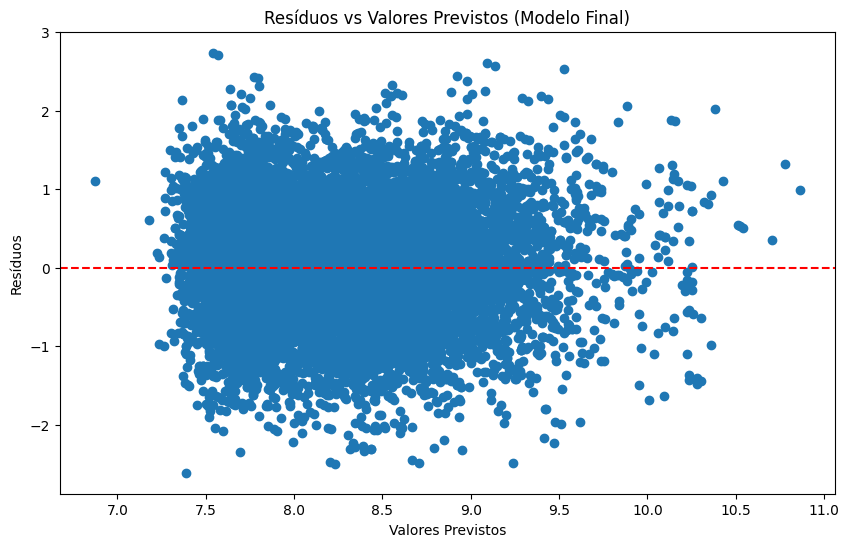

In [31]:
# Plotar resíduos do modelo final
plt.figure(figsize=(10, 6))
plt.scatter(final_model.fittedvalues, final_model.resid)
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Previstos (Modelo Final)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [32]:
# Variáveis mantidas no modelo final
final_vars = set(final_model.params.index) - {'Intercept'}
initial_vars = set(initial_model.params.index) - {'Intercept'}
print(f"\nVariáveis removidas: {initial_vars - final_vars}")
print(f"Variáveis mantidas: {final_vars}")


Variáveis removidas: set()
Variáveis mantidas: {"C(estado_civil, Treatment(reference='Casado'))[T.Viúvo]", "C(educacao, Treatment(reference='Secundário'))[T.Pós graduação]", "C(data_ref, Treatment(reference='2015-09-01'))[T.2015-03-01]", "C(data_ref, Treatment(reference='2015-09-01'))[T.2015-10-01]", 'posse_de_imovel[T.True]', "C(educacao, Treatment(reference='Secundário'))[T.Primário]", "C(educacao, Treatment(reference='Secundário'))[T.Superior completo]", "C(tipo_renda, Treatment(reference='Assalariado'))[T.Bolsista]", "C(tipo_residencia, Treatment(reference='Casa'))[T.Com os pais]", "C(data_ref, Treatment(reference='2015-09-01'))[T.2016-03-01]", "C(estado_civil, Treatment(reference='Casado'))[T.União]", "C(data_ref, Treatment(reference='2015-09-01'))[T.2015-02-01]", 'qt_pessoas_residencia', "C(data_ref, Treatment(reference='2015-09-01'))[T.2015-08-01]", "C(data_ref, Treatment(reference='2015-09-01'))[T.2016-01-01]", "C(data_ref, Treatment(reference='2015-09-01'))[T.2015-01-01]", "C